In [26]:
#pip install scikit-learn yellowbrick

In [27]:
#pip install aif360==0.2.2

In [28]:
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
import random
random.seed(6)
import copy
import sys
import warnings
import pandas as pd
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import KFold, train_test_split
from aif360.datasets import AdultDataset, StandardDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
import time
from scipy.linalg import sqrtm
from collections import Counter


In [29]:
label_map = {1.0: '>50K', 0.0: '<=50K'}
protected_attribute_maps = [{1.0: 'Male', 0.0: 'Female'}]

dataset_orig = AdultDataset(
    protected_attribute_names=['sex'],
    categorical_features=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country', 'race']
    ,features_to_drop=['fnlwgt'],privileged_classes=[['Male']],
    metadata={'label_map': label_map, 'protected_attribute_maps': protected_attribute_maps}
)

In [30]:
protected_attribute='sex'
target_attribute='income-per-year'
privileged_group=1.0
protected_group=0.0
positive_outcome=1.0
negative_outcome=0.0

In [31]:
data_half1, data_half2 = dataset_orig.split([0.1], shuffle=True, seed= 10)
train_orig, test_orig = data_half1.split([0.8], shuffle=True, seed=10)
dataset_orig_df,_=dataset_orig.convert_to_dataframe()
data_half2_df, _= data_half2.convert_to_dataframe()
train_orig_df, _ = train_orig.convert_to_dataframe()
test_orig_df, _ = test_orig.convert_to_dataframe()


print("Train set: ", train_orig_df.shape)
print("Test set: ", test_orig_df.shape)

Train set:  (3617, 103)
Test set:  (905, 103)


In [32]:

male_positive = data_half2_df[(data_half2_df[protected_attribute] == privileged_group) & (data_half2_df['income-per-year'] == positive_outcome)]
male_negative = data_half2_df[(data_half2_df[protected_attribute] == privileged_group) & (data_half2_df['income-per-year'] == negative_outcome)]
female_positive = data_half2_df[(data_half2_df[protected_attribute] == protected_group) & (data_half2_df['income-per-year'] == positive_outcome)]
female_negative = data_half2_df[(data_half2_df[protected_attribute] == protected_group) & (data_half2_df['income-per-year'] == negative_outcome)]


Male with Positive Outcome:  (8593, 103)
Male with Negative Outcome:  (18937, 103)
Female with Positive Outcome:  (1508, 103)
Female with Negative Outcome:  (11662, 103)


In [33]:
privileged_group = data_half2_df[data_half2_df[protected_attribute] == privileged_group]
unprivileged_group = data_half2_df[data_half2_df[protected_attribute] == protected_group]

privileged_positive_rate_ac = sum(privileged_group[target_attribute] == positive_outcome) / len(privileged_group)
unprivileged_positive_rate_ac = sum(unprivileged_group[target_attribute] == positive_outcome) / len(unprivileged_group)

0.3121322193970214
0.11450265755504936


In [35]:
def calculate_gender_disparity(data_df, protected_attribute, privileged_group, protected_group, target_attribute, positive_outcome, negative_outcome):
    priv_positive = data_df[(data_df[protected_attribute] == privileged_group) & (data_df[target_attribute] == positive_outcome)]
    prot_positive = data_df[(data_df[protected_attribute] == protected_group) & (data_df[target_attribute] == positive_outcome)]
    priv_positive_rate = len(priv_positive) / len(data_df[data_df[protected_attribute] == privileged_group])
    prot_positive_rate = len(prot_positive) / len(data_df[data_df[protected_attribute] == protected_group])
    gender_disparity = priv_positive_rate - prot_positive_rate
    return gender_disparity


In [36]:
protected_attribute='sex'
target_attribute='income-per-year'
privileged_group=1.0
protected_group=0.0
positive_outcome=1.0
negative_outcome=0.0

Gender Disparity: 0.19762956184197206


In [38]:
x_train = train_orig_df.drop("income-per-year", axis=1)
y_train = train_orig_df["income-per-year"]
print("Outcomes: ")
y_train.value_counts()

Outcomes: 


income-per-year
0.0    2755
1.0     862
Name: count, dtype: int64

In [39]:
initial_lr = LogisticRegression(C=0.5, penalty="l1", solver='liblinear')
initial_lr = initial_lr.fit(x_train, y_train, sample_weight=None)

In [40]:
def evaluate(model, X, y_true):
    y_pred = model.predict_proba(X)
    y_pred = [row[1] for row in y_pred] 
    y_pred_binary =(np.array(y_pred) >= 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_binary)   
    return accuracy

In [41]:
def calculate_statistical_parity(model, x_test, target_col, protected_col, privileged_class):
    y_pred = model.predict(x_test)
    test_preds_df = x_test.copy()
    test_preds_df[target_col] = y_pred
    privileged_positive_rate = test_preds_df[test_preds_df[protected_col] == privileged_class][target_col].mean()
    unprivileged_positive_rate = test_preds_df[test_preds_df[protected_col] != privileged_class][target_col].mean()
    statistical_parity_difference = unprivileged_positive_rate - privileged_positive_rate   
    return statistical_parity_difference

In [42]:
x_test = test_orig_df.drop("income-per-year", axis=1)
y_test = test_orig_df["income-per-year"]

In [43]:
accuracy= evaluate(initial_lr, x_test, y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.8386740331491712


In [44]:
stat_parity_diff = calculate_statistical_parity(initial_lr, x_test, target_attribute, protected_attribute, privileged_group)
print(f"Statistical Parity Difference: {stat_parity_diff}")

Statistical Parity Difference: -0.2101789480846431


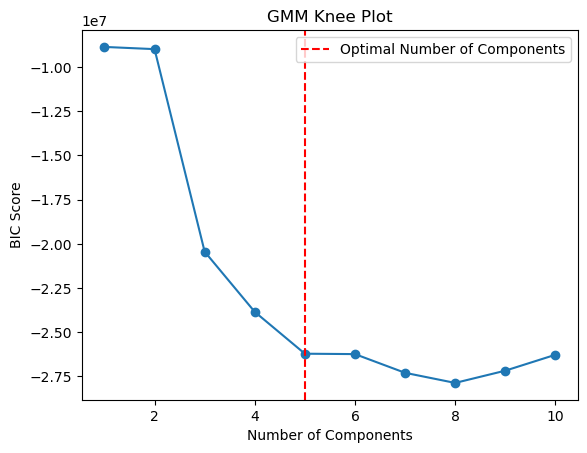

Cluster 1 shape: (3257, 103)
Cluster 2 shape: (205, 103)
Cluster 3 shape: (5034, 103)
Cluster 4 shape: (25569, 103)
Cluster 5 shape: (6635, 103)


In [45]:
n_components_range = range(1, 11)
bic_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data_half2_df)
    bic_scores.append(gmm.bic(data_half2_df))

kneedle_gmm = KneeLocator(list(n_components_range), bic_scores, curve="convex", direction="decreasing")
optimal_num_components_gmm = kneedle_gmm.knee

plt.plot(n_components_range, bic_scores, marker='o')
plt.title('GMM Knee Plot')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.axvline(optimal_num_components_gmm, color='r', linestyle='--', label='Optimal Number of Components')
plt.legend()
plt.show()

gmm = GaussianMixture(n_components=optimal_num_components_gmm, random_state=42)
gmm.fit(data_half2_df)
clusters_gmm = gmm.predict(data_half2_df)
clustered_data = []

for i in range(optimal_num_components_gmm):
    cluster_i_indices = np.where(clusters_gmm == i)[0]
    cluster_i_data = data_half2_df.iloc[cluster_i_indices, :]
    clustered_data.append(cluster_i_data)
    print(f"Cluster {i+1} shape: {cluster_i_data.shape}")

In [46]:
num_clusters=len(clustered_data)
def Euclid_distance(cluster1, cluster2, reg_term=1e-3):
    mean1 = np.mean(cluster1, axis=0)
    cov1 = np.cov(cluster1, rowvar=False) 
    
    mean2 = np.mean(cluster2, axis=0)
    cov2 = np.cov(cluster2, rowvar=False) 
    distance = (np.linalg.norm(mean1 - mean2) ** 2)
    return distance

d = np.zeros((num_clusters, num_clusters))
for i in range(num_clusters):
    for j in range(num_clusters):
            distance = Euclid_distance(clustered_data[i],clustered_data[j])
            d[i,j]=distance

min_distance = np.min(d)
max_distance = np.max(d)
Euclid_normalized_d = (d - min_distance) / (max_distance - min_distance)

print("Normalized Matrix:")
print(Euclid_normalized_d)

Normalized Matrix:
[[0.00000000e+00 1.00000000e+00 2.89816363e-04 1.38173695e-04
  1.21603942e-04]
 [1.00000000e+00 0.00000000e+00 9.74048069e-01 9.91559451e-01
  9.98083541e-01]
 [2.89816363e-04 9.74048069e-01 0.00000000e+00 7.80064899e-05
  1.46477411e-04]
 [1.38173695e-04 9.91559451e-01 7.80064899e-05 0.00000000e+00
  1.06979747e-05]
 [1.21603942e-04 9.98083541e-01 1.46477411e-04 1.06979747e-05
  0.00000000e+00]]


In [47]:
dist = 0.0001
def find_neighbors(clusters):
    num_clusters = len(clusters)
    neighbors = {i: set() for i in range(num_clusters)}
    
    for i in range(num_clusters):
        for j in range(num_clusters):
                distance=Euclid_normalized_d[i,j]
                if distance <= dist:
                    neighbors[i].add(j)
                    neighbors[j].add(i)    
    return neighbors


{0: {0}, 1: {1}, 2: {2, 3}, 3: {2, 3}}
0


In [48]:
def ucb_mab_algorithm_stat(partition_data, Ttrain, x_test, y_test, Model,target_col,protected_col,privileged_col, tau, total_iterations):
    clusters=partition_data.copy()
    ini_parity = calculate_statistical_parity(Model, x_test, target_col, protected_col, privileged_col)
    best_parity=ini_parity
    ini_acc=evaluate(Model, x_test, y_test)  
    stat_ex = [ini_parity]
    i_values_stat = [0]
    i_values_ex_stat = [0]
    iteration_no = 0
    train_shape = []
    cluster_count = []
    time_per_iteration_stat = [0]
    time_per_iteration_ex = [0]
    iteration_time1 = [0]
    stat = [ini_parity]
    acc_stat = [ini_acc]
    stat_ex = [ini_parity]
    acc_ex=[]
    k=total_iterations
    alpha=0.1
    Ttrain_updated = Ttrain.copy()
    print('initial Shape', Ttrain_updated.shape)
    #best_parity = calculate_statistical_parity(Model, x_test, y_test, protected_attribute='sex', privileged_classes=[[1]], favorable_classes=[1])
    num_clusters = len(clusters)
    r = np.zeros((k, num_clusters))
    R = np.zeros((k, num_clusters))
    n = np.zeros((k, num_clusters))
    br = np.zeros((num_clusters))
    U = np.zeros((num_clusters))
    cumulative_time = 0
    M=copy.deepcopy(Model)
    for iteration in range(1, total_iterations):
        start_time = time.time()
        max_indices = np.where(U == np.max(U))[0]
        selected_index = np.random.choice(max_indices)
        selected_cluster_indices = selected_index
        exhausted_clusters = set()  
        while len(clusters[selected_cluster_indices]) < tau:
            exhausted_clusters.add(selected_cluster_indices)
            U[list(exhausted_clusters)] = -np.inf
            new_selected_cluster_indices = np.argmax(U)
            if new_selected_cluster_indices == selected_cluster_indices:
                break
            selected_cluster_indices = new_selected_cluster_indices
        if len(clusters[selected_cluster_indices]) < tau:
            break
        #print(f'Cluster {selected_cluster_indices+1} iteration number {iteration}')
        mini_batch_indices = np.random.choice(len(clusters[selected_cluster_indices]), size=tau, replace=True)
        mini_batch = clusters[selected_cluster_indices].iloc[mini_batch_indices]
        combined_features = np.vstack([Ttrain_updated.drop(target_col, axis=1).values, mini_batch.drop(target_col, axis=1).values])
        combined_labels = np.concatenate([Ttrain_updated[target_col].values, mini_batch[target_col].values])

        Ttrain_updated_combined = pd.DataFrame(data=combined_features, columns=Ttrain_updated.drop(target_col, axis=1).columns)
        Ttrain_updated_combined[target_col] = combined_labels

        #before = calculate_statistical_parity(M, x_test, y_test, protected_attribute='sex', privileged_classes=[[1]], favorable_classes=[1])
        before= calculate_statistical_parity(M, x_test, target_col, protected_col, privileged_col)
        model_up = M.fit(Ttrain_updated_combined.drop(target_col, axis=1), Ttrain_updated_combined[target_col], sample_weight=None)
        #after = calculate_statistical_parity(model_up, x_test, y_test, protected_attribute='sex', privileged_classes=[[1]], favorable_classes=[1])
        after = calculate_statistical_parity(model_up, x_test, target_col, protected_col, privileged_col)
        accuracy_1 = evaluate(model_up, x_test, y_test)
        delta = np.abs(after) - np.abs(before)
        if delta > 0:
            cluster_df = clusters[selected_cluster_indices]
            mini_batch_indices = list(mini_batch_indices)
            cluster_df = cluster_df.drop(cluster_df.index[mini_batch_indices])
            clusters[selected_cluster_indices] = cluster_df
        if delta < 0 and np.abs(after) < np.abs(best_parity):
            Ttrain_updated = Ttrain_updated_combined
            M = model_up
            i_values_ex_stat.append(iteration)
            stat_ex.append(after)
            acc_ex.append(accuracy_1)
            train_shape.append(Ttrain_updated.shape)
            cluster_count.append(selected_cluster_indices + 1)
            cluster_df = clusters[selected_cluster_indices]
            mini_batch_indices = list(mini_batch_indices)
            cluster_df = cluster_df.drop(cluster_df.index[mini_batch_indices])
            clusters[selected_cluster_indices] = cluster_df
            if after > best_parity:
                best_parity = after
                iteration_no = iteration
                

        for j in range(num_clusters):
                br[j]=calculate_gender_disparity(clusters[j], protected_col, privileged_col, 0.0, target_col, 1.0, 0.0)
                if j==selected_cluster_indices:
                    r[iteration, j] = -(delta*0.8) /(1 + (br[j])**2)
                    n[iteration, j] = n[iteration - 1, j] + (r[iteration, j] > 0).astype(int)                   
                else:
                    r[iteration, j] = -(delta*0.2) / (1 + (br[j])**2)
                    n[iteration, j] = n[iteration - 1, j]

                R[iteration, j] = np.sum(r[:, j]) / (n[iteration, j] + 1)
                U[j] = R[iteration, j] + alpha * np.sqrt(2 * np.log(np.sum(n[iteration, :]) + 1) / (2*(n[iteration, j]) + 1))
    
        end_time = time.time()
        iteration_time = end_time - start_time
        cumulative_time += iteration_time
        iteration_time1.append(iteration_time)
        time_per_iteration_stat.append(cumulative_time)
        i_values_stat.append(iteration)
        stat.append(after)
        acc_stat.append(accuracy_1)
    print(clusters[0].shape)
    print(clusters[1].shape)
    print(clusters[2].shape)
    print(clusters[3].shape)

    

    return Ttrain_updated, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count,iteration_time1


In [49]:

def random_algorithm(clusters, Ttrain, x_test, y_test, M, target_col, protected_col, privileged_col, tau, total_iterations):
    Ttrain_updated = Ttrain.copy()
    print('initial Shape',Ttrain_updated.shape)
    best_parity = calculate_statistical_parity(M, x_test, target_col, protected_col, privileged_col)
    ini_parity = calculate_statistical_parity(M, x_test, target_col, protected_col, privileged_col)
    ini_acc=evaluate(M, x_test, y_test)
    cumulative_time = 0
    stat_ex_ran=[ini_parity]
    i_values_ran=[0]
    i_values_ex_ran=[0]
    iteration_no=0
    train_shape=[]
    cluster_count=[]
    time_per_iteration = [0]
    time_per_iteration_ran = [0]
    iteration_time1=[0]
    stat_ran=[ini_parity]
    acc_ran=[ini_acc]
    acc_ex=[]
    for iteration in range(1,total_iterations):
        start_time = time.time()
    
        mini_batch_indices = np.random.choice(len(clusters), size=tau, replace=False)
        mini_batch = clusters.iloc[mini_batch_indices]
        combined_features = np.vstack([Ttrain_updated.drop(target_col, axis=1).values, mini_batch.drop(target_col, axis=1).values])
        combined_labels = np.concatenate([Ttrain_updated[target_col].values, mini_batch[target_col].values])

        Ttrain_updated_combined = pd.DataFrame(data=combined_features, columns=Ttrain_updated.drop(target_col, axis=1).columns)
        Ttrain_updated_combined[target_col] = combined_labels
        
        before = calculate_statistical_parity(M, x_test, target_col, protected_col, privileged_col)
        model_up = M.fit(Ttrain_updated_combined.drop(target_col, axis=1), Ttrain_updated_combined[target_col], sample_weight=None)
        after = calculate_statistical_parity(model_up, x_test, target_col, protected_col, privileged_col)
        accuracy_1 = evaluate(model_up, x_test, y_test)
        delta = after - before
        print(f'The statistical parity after {iteration}th iteration is {after:.4f}')
        if delta > 0 and after > best_parity:
            Ttrain_updated = Ttrain_updated_combined
            M = model_up
            i_values_ex_ran.append(iteration)
            stat_ex_ran.append(after)
            acc_ex.append(accuracy_1)
            train_shape.append(Ttrain_updated.shape)
            if after > best_parity:
                best_parity = after
                iteration_no = iteration

        end_time = time.time()
        iteration_time = end_time - start_time
        cumulative_time += iteration_time
        iteration_time1.append(iteration_time)
        time_per_iteration.append(iteration_time)
        time_per_iteration_ran.append(cumulative_time)
        i_values_ran.append(iteration)
        stat_ran.append(after)
        acc_ran.append(accuracy_1)
        
    plt.figure(1)
    plt.plot(i_values_ran, stat_ran, marker='o', linestyle='-', label='Updated fairness')
    plt.axhline(y=ini_parity, color='r', linestyle='--', label='Initial fairness')
    plt.xlabel('Iteration')
    plt.ylabel('Statistical Parity')
    plt.title('Fairness observed Random Acquisition')
    plt.legend()
    
    plt.figure(2)
    plt.plot(i_values_ran, time_per_iteration, marker='o', linestyle='-', label='Time per Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Time Taken')
    plt.title('Time Taken per Iteration')
    plt.legend()
    
    plt.figure(3)
    plt.plot(i_values_ran, time_per_iteration_ran, marker='o', linestyle='-', label='Cumulative Time Taken')
    plt.xlabel('Iteration')
    plt.ylabel('Cumulative Time Taken')
    plt.title('Cumulative Time Taken')
    plt.legend()

    plt.figure(4)
    plt.plot(i_values_ex_ran, stat_ex_ran, marker='o', linestyle='-', label='Updated accuracy')
    plt.axhline(y=ini_parity, color='r', linestyle='--', label='Initial Accuracy')
    '''for i, y_value in enumerate(stat_ex):
        plt.scatter(i_values_ex[i], y_value, color='blue', s=100, edgecolors='blue', linewidths=2)
        plt.text(i_values_ex[i] - 0.2, y_value, f'Cluster {cluster_count[i]+1}, {train_shape[i]}', ha='right', va='top', rotation='vertical', fontsize=8, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))
    plt.xlabel('iteration')'''
    plt.ylabel('Statistical parity')
    plt.title('fairness observe when data acquired by random')
    plt.legend()
    
    plt.show()

    plt.figure(5)
    plt.plot(i_values_ran, acc_ran, marker='o', linestyle='-', label='Updated accuarcy')
    plt.axhline(y=ini_acc, color='r', linestyle='--', label='Initial accuracy')
    plt.xlabel('iteration')
    plt.ylabel('Accuracy')
    plt.title('Accuracy evaluation for each iteration')
    plt.legend()
    
    
    return Ttrain_updated, i_values_ex_ran, i_values_ran, stat_ran, stat_ex_ran, ini_parity, acc_ran, time_per_iteration_ran



In [50]:
male_data_1 = dataset_orig_df[dataset_orig_df['sex'] == 1]
male_data_2 = dataset_orig_df[dataset_orig_df['income-per-year'] == 1]
male_train_11=male_train_sampled = male_data_1.sample(n=700, replace=True, random_state=42)
male_train_22=male_train_sampled = male_data_2.sample(n=5000, replace=True, random_state=42)
male_data = pd.concat([male_train_11, male_train_22])
female_data = dataset_orig_df[dataset_orig_df['sex'] == 0]

male_train, male_test = train_test_split(male_data, test_size=0.1, random_state=42)
female_train, female_test = train_test_split(female_data, test_size=0.1, random_state=42)

total_train_size = 3000
male_train_size = int(total_train_size * 0.9)
female_train_size = total_train_size - male_train_size

male_train_sampled = male_train.sample(n=male_train_size, replace=True, random_state=42)
female_train_sampled = female_train.sample(n=female_train_size, replace=True, random_state=42)
print(female_train_sampled.shape)

final_train_data_re = pd.concat([male_train_sampled, female_train_sampled])
#print('final', final_train_data_re.shape)

final_train_data_re = final_train_data_re.sample(frac=1, random_state=42).reset_index(drop=True)
print('final', final_train_data_re.shape)

(300, 103)
final (3000, 103)


In [51]:
privileged_group_re = final_train_data_re[final_train_data_re['sex'] == 1.0]
unprivileged_group_re = final_train_data_re[final_train_data_re['sex'] == 0.0]

privileged_positive_rate = sum(privileged_group_re['income-per-year'] == 1) / len(privileged_group_re)
unprivileged_positive_rate = sum(unprivileged_group_re['income-per-year'] == 1) / len(unprivileged_group_re)
print(privileged_positive_rate)
print(unprivileged_positive_rate)

0.9178433889602053
0.5912518853695324


In [52]:
x_train = final_train_data_re.drop("income-per-year", axis=1)
y_train = final_train_data_re["income-per-year"]
print("Outcomes: ")
y_train.value_counts()

Outcomes: 


income-per-year
1.0    2537
0.0     463
Name: count, dtype: int64

In [53]:
initial_lr_1 = LogisticRegression(C=0.5, penalty="l1", solver='liblinear')
initial_lr_1 = initial_lr_1.fit(x_train, y_train, sample_weight=None)

In [54]:
ini_acc= evaluate(initial_lr_1, x_test, y_test)
print("Accuracy: ", accuracy)
ini_parity = calculate_statistical_parity(initial_lr_1, x_test, target_attribute, protected_attribute, privileged_group)
print(f"Statistical Parity Difference: {ini_parity}")

Accuracy:  0.8386740331491712
Statistical Parity Difference: -0.4870268308725137


In [55]:
Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = ucb_mab_algorithm_stat(clustered_data, final_train_data_re, x_test,y_test, initial_lr_1, target_attribute, protected_attribute,privileged_group, 1000, total_iterations=50)

initial Shape (3000, 103)
(844, 103)
(205, 103)
(786, 103)
(1847, 103)


In [57]:
initial_lr_2 = LogisticRegression(C=0.5, penalty="l1", solver='liblinear')
initial_lr_2 = initial_lr_2.fit(x_train, y_train, sample_weight=None)

initial Shape (3000, 103)
The statistical parity after 1th iteration is -0.4405
The statistical parity after 2th iteration is -0.3969
The statistical parity after 3th iteration is -0.3886
The statistical parity after 4th iteration is -0.3596
The statistical parity after 5th iteration is -0.3492
The statistical parity after 6th iteration is -0.3282
The statistical parity after 7th iteration is -0.3269
The statistical parity after 8th iteration is -0.3141
The statistical parity after 9th iteration is -0.3079
The statistical parity after 10th iteration is -0.2915
The statistical parity after 11th iteration is -0.2905
The statistical parity after 12th iteration is -0.2895
The statistical parity after 13th iteration is -0.2930
The statistical parity after 14th iteration is -0.2863
The statistical parity after 15th iteration is -0.2798
The statistical parity after 16th iteration is -0.2785
The statistical parity after 17th iteration is -0.2705
The statistical parity after 18th iteration is -

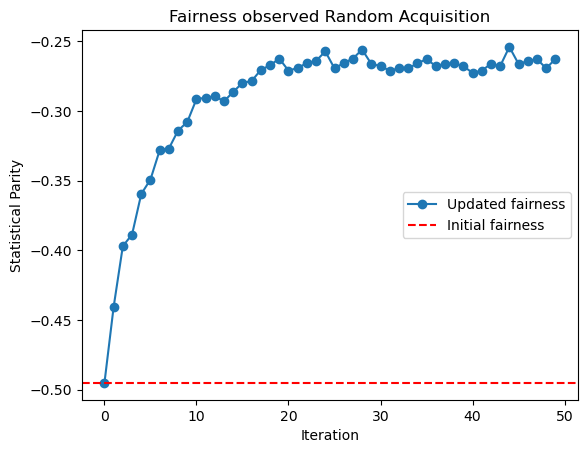

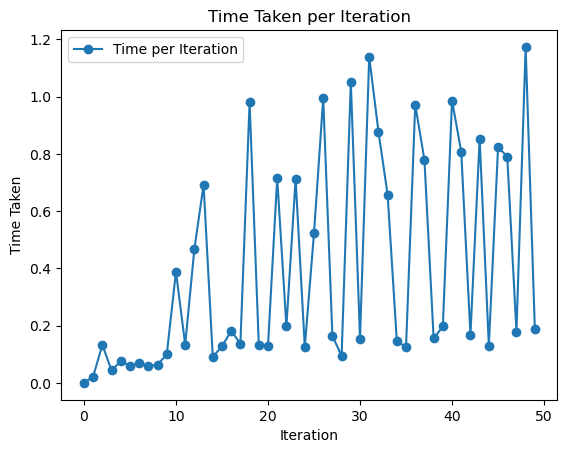

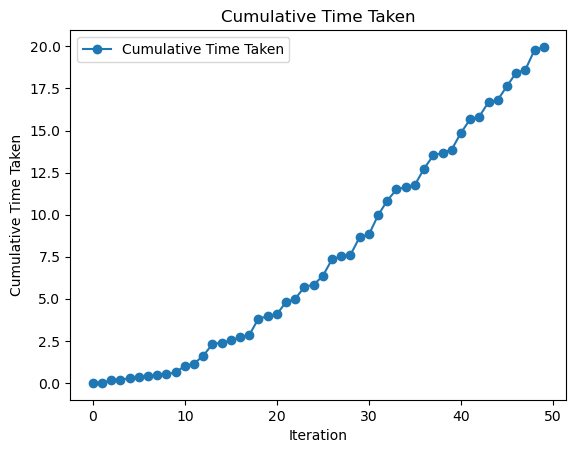

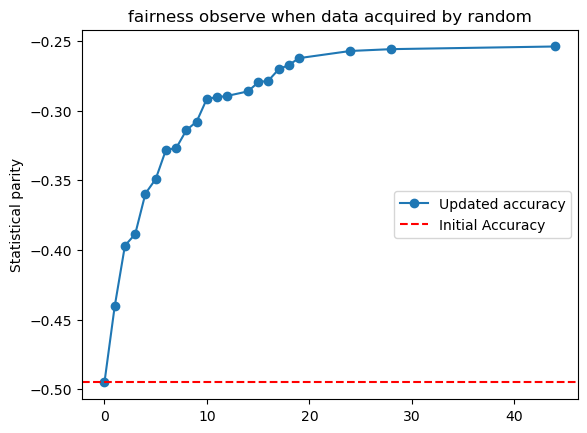

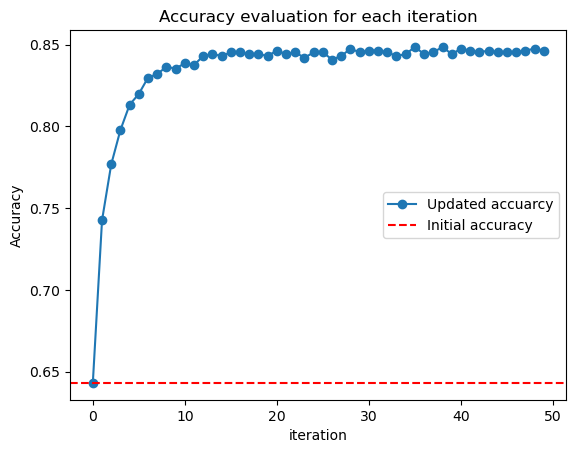

In [58]:
data_random, i_values_ex_ran, i_values_ran, stat_ran, stat_ex_ran, ini_parity, acc_ran, time_per_iteration_ran =random_algorithm(data_half2_df, final_train_data_re, x_test,y_test, initial_lr_2, target_attribute, protected_attribute, privileged_group, tau=1000, total_iterations=50)

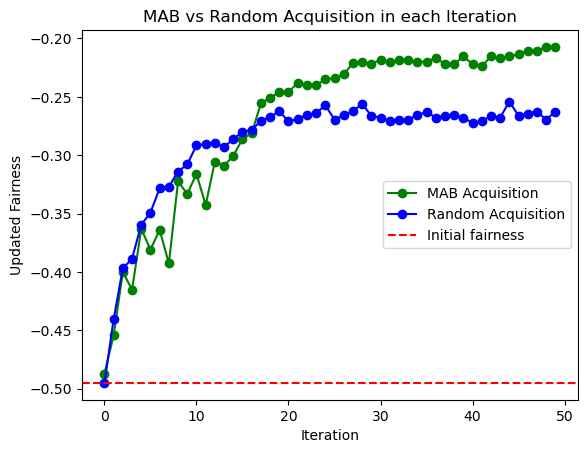

In [59]:
plt.plot(i_values_stat, stat, color='g',marker='o', linestyle='-', label='MAB Acquisition')
plt.plot(i_values_ran, stat_ran, color='b', marker='o', linestyle='-', label='Random Acquisition')
plt.axhline(y=ini_parity, color='r', linestyle='--', label='Initial fairness')

plt.xlabel('Iteration')
plt.ylabel('Updated Fairness')
plt.title('MAB vs Random Acquisition in each Iteration')
plt.legend()
plt.savefig('combined_plot.png', dpi=1200)
plt.show()


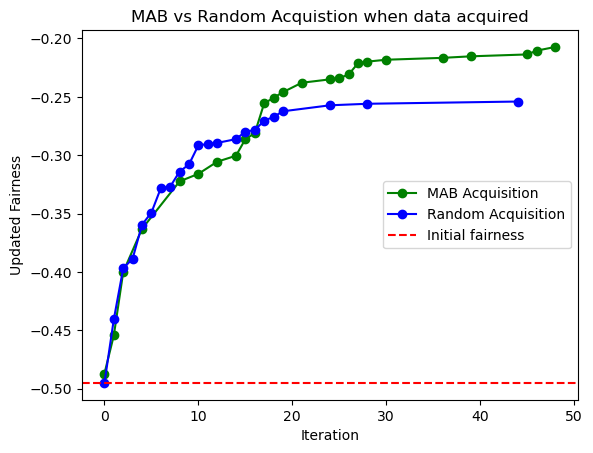

In [60]:
plt.plot(i_values_ex_stat, stat_ex,color='g', marker='o', linestyle='-', label='MAB Acquisition')
plt.plot(i_values_ex_ran, stat_ex_ran, marker='o', color='b', linestyle='-', label='Random Acquisition')
plt.axhline(y=ini_parity, color='r', linestyle='--', label='Initial fairness')

plt.xlabel('Iteration')
plt.ylabel('Updated Fairness')
plt.title('MAB vs Random Acquistion when data acquired')
plt.legend()
plt.savefig('combined_plot_acquisition.png', dpi=1200)
plt.show()

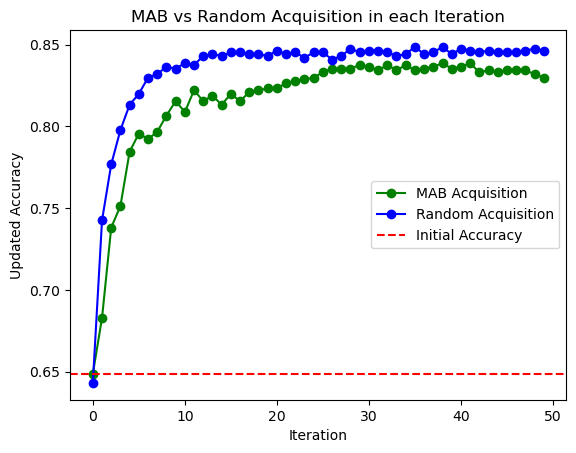

In [61]:
plt.plot(i_values_stat, acc_stat, color='g',marker='o', linestyle='-', label='MAB Acquisition')
plt.plot(i_values_ran, acc_ran, color='b', marker='o', linestyle='-', label='Random Acquisition')
plt.axhline(y=ini_acc, color='r', linestyle='--', label='Initial Accuracy')

plt.xlabel('Iteration')
plt.ylabel('Updated Accuracy')
plt.title('MAB vs Random Acquisition in each Iteration')
plt.legend()
plt.savefig('combined_plot.png', dpi=1200)
plt.show()

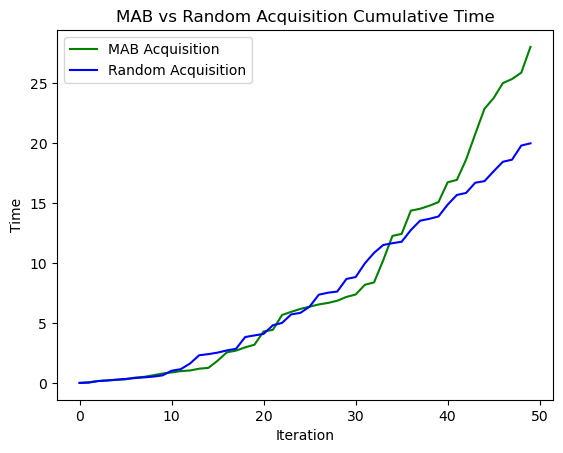

In [62]:
plt.plot(i_values_stat, time_per_iteration_stat, color='g', linestyle='-', label='MAB Acquisition')
plt.plot(i_values_ran, time_per_iteration_ran, color='b', linestyle='-', label='Random Acquisition')

plt.xlabel('Iteration')
plt.ylabel('Time')
plt.title('MAB vs Random Acquisition Cumulative Time')
plt.legend()
plt.savefig('combined_plot.png', dpi=1200)
plt.show()